In [356]:
import sqlite3
from rosidl_runtime_py.utilities import get_message
from rclpy.serialization import deserialize_message

import matplotlib.pyplot as plt

import numpy as np


In [357]:
class BagFileParser():
    """reference: https://answers.ros.org/question/358686/how-to-read-a-bag-file-in-ros2/"""

    def __init__(self, bag_file):
        self.conn = sqlite3.connect(bag_file)
        self.cursor = self.conn.cursor()

        # create a message type map
        topics_data = self.cursor.execute(
            "SELECT id, name, type FROM topics").fetchall()
        self.topic_type = {name_of: type_of for id_of,
                           name_of, type_of in topics_data}
        self.topic_id = {name_of: id_of for id_of,
                         name_of, type_of in topics_data}
        self.topic_msg_message = {name_of: get_message(
            type_of) for id_of, name_of, type_of in topics_data}

    def __del__(self):
        self.conn.close()

    # Return [(timestamp0, message0), (timestamp1, message1), ...]
    def get_messages(self, topic_name):

        topic_id = self.topic_id[topic_name]
        # Get from the db
        rows = self.cursor.execute(
            "SELECT timestamp, data FROM messages WHERE topic_id = {}".format(topic_id)).fetchall()
        # Deserialise all and timestamp them
        return [(timestamp, deserialize_message(data, self.topic_msg_message[topic_name])) for timestamp, data in rows]


## Get parameters of camera


In [358]:
# bag_filename = 'data/hw4_example3.bag/rosbag2_2023_03_11-19_45_01_0.db3'
bag_filename = 'data/hw4_example1.bag/rosbag2_2023_03_11-16_24_43_0.db3'

parser = BagFileParser(bag_filename)
msgs = parser.get_messages("/depth_camera/camera_info")

timestamp, msg = msgs[0]


In [359]:
msg


sensor_msgs.msg.CameraInfo(header=std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=130, nanosec=600000000), frame_id='camera_link'), height=480, width=640, distortion_model='plumb_bob', d=[0.0, 0.0, 0.0, 0.0, 0.0], k=array([565.60089528,   0.        , 320.5       ,   0.        ,
       565.60089528, 240.5       ,   0.        ,   0.        ,
         1.        ]), r=array([1., 0., 0., 0., 1., 0., 0., 0., 1.]), p=array([565.60089528,   0.        , 320.5       ,  -0.        ,
         0.        , 565.60089528, 240.5       ,   0.        ,
         0.        ,   0.        ,   1.        ,   0.        ]), binning_x=0, binning_y=0, roi=sensor_msgs.msg.RegionOfInterest(x_offset=0, y_offset=0, height=0, width=0, do_rectify=False))

In [360]:
p = np.reshape(msg.p, (3, 4))


## Get sample image


In [361]:
images = parser.get_messages("/depth_camera/image_raw")

timestamp, image = images[0]

img = np.array(image.data, dtype=np.uint8)

img = np.reshape(img, (image.height, image.width, 3))


In [371]:
image.encoding

'rgb8'

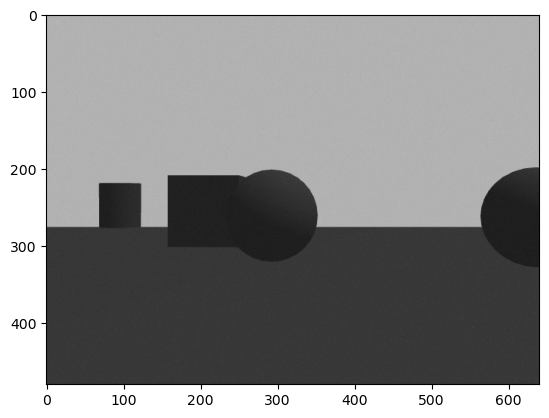

In [362]:
plt.imshow(img)


## Get sample from lidar


In [363]:
from sensor_msgs.msg._laser_scan import LaserScan

scans = parser.get_messages("/hagen/scan")

timestamp, scan = scans[0]

scan.ranges, scan.angle_min, scan.angle_max

(array('f', [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, in

In [364]:


def lidar2pos(scan: LaserScan) -> np.ndarray:
    # generate array of angles
    angles = np.arange(scan.angle_min, scan.angle_max, scan.angle_increment)

    poses = []
    for angle, range in zip(angles, scan.ranges):
        if range == np.inf:
            continue

        poses.append(
            np.array([
                np.cos(angle) * range,
                np.sin(angle) * range,
                0,
            ]),
        )

    return np.array(poses)


res = lidar2pos(scan)

res, res.shape


(array([[ 4.01435066e+00, -2.72532982e+00,  0.00000000e+00],
        [ 4.00660459e+00, -2.69457137e+00,  0.00000000e+00],
        [ 3.97484899e+00, -2.64806538e+00,  0.00000000e+00],
        [ 3.97412897e+00, -2.62258690e+00,  0.00000000e+00],
        [ 3.94732722e+00, -2.58021260e+00,  0.00000000e+00],
        [ 3.93533269e+00, -2.54790004e+00,  0.00000000e+00],
        [ 3.93716964e+00, -2.52474385e+00,  0.00000000e+00],
        [ 3.93525931e+00, -2.49932112e+00,  0.00000000e+00],
        [ 3.90134404e+00, -2.45392482e+00,  0.00000000e+00],
        [ 3.93637340e+00, -2.45201945e+00,  0.00000000e+00],
        [ 3.91858687e+00, -2.41723887e+00,  0.00000000e+00],
        [ 3.91220360e+00, -2.38976597e+00,  0.00000000e+00],
        [ 3.92694474e+00, -2.37527238e+00,  0.00000000e+00],
        [ 3.92273226e+00, -2.34937516e+00,  0.00000000e+00],
        [ 3.93782160e+00, -2.33509565e+00,  0.00000000e+00],
        [ 3.94624629e+00, -2.31684560e+00,  0.00000000e+00],
        [ 3.94329581e+00

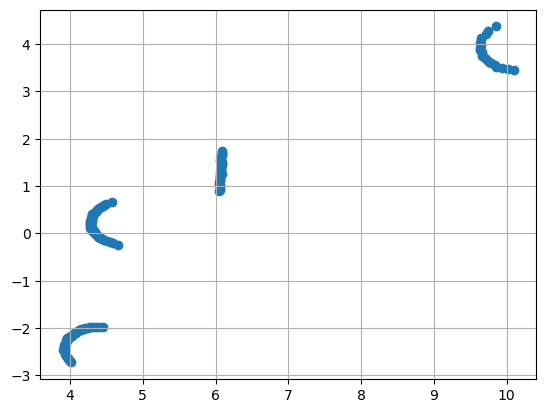

In [365]:
plt.scatter(res[:, 0], res[:, 1])
plt.grid(True)

In [368]:
image_points = []
for p3d in res:
    x, y, z = p3d[0], p3d[1], p3d[2]
    # image_points.append(camera.project3dToPixel((-y, -z, x)))

    u = p @ np.array([-y, -z, x, 1])
    x, y = u[0] / u[2], u[1] / u[2]
    image_points.append(np.array([x, y]))

image_points = np.array(image_points)

image_points

array([[704.4846382 , 240.5       ],
       [700.88492337, 240.5       ],
       [697.30630262, 240.5       ],
       [693.74845562, 240.5       ],
       [690.21106735, 240.5       ],
       [686.69382791, 240.5       ],
       [683.19643249, 240.5       ],
       [679.71858121, 240.5       ],
       [676.25997899, 240.5       ],
       [672.82033552, 240.5       ],
       [669.39936504, 240.5       ],
       [665.99678636, 240.5       ],
       [662.61232267, 240.5       ],
       [659.24570149, 240.5       ],
       [655.89665455, 240.5       ],
       [652.56491771, 240.5       ],
       [649.25023088, 240.5       ],
       [645.95233791, 240.5       ],
       [642.67098652, 240.5       ],
       [639.4059282 , 240.5       ],
       [636.15691817, 240.5       ],
       [632.92371523, 240.5       ],
       [629.70608176, 240.5       ],
       [626.50378357, 240.5       ],
       [623.3165899 , 240.5       ],
       [620.14427328, 240.5       ],
       [616.9866095 , 240.5       ],
 

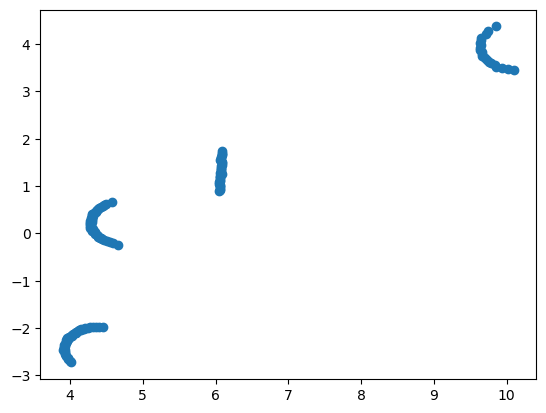

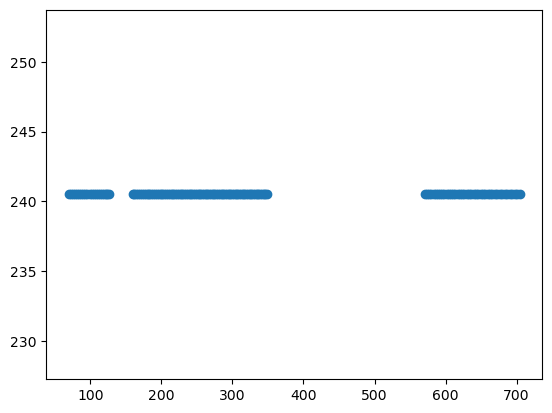

In [369]:
plt.figure()
plt.scatter(res[:, 0], res[:, 1])

plt.figure()
plt.scatter(image_points[:, 0], image_points[:, 1])

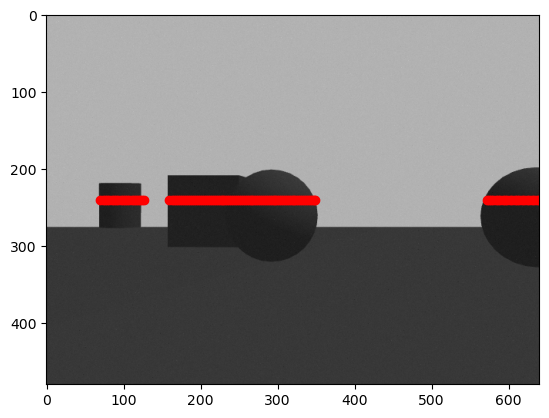

In [370]:
plt.figure()
plt.imshow(img)

filtered = []
for (x, y) in image_points:
    if 0 <= x <= 640 and 0 <= y <= 480:
        filtered.append((x, y))

filtered = np.array(filtered)
plt.scatter(filtered[:, 0], filtered[:, 1], color='red')
